In [130]:
#!pip install scikit-image
#!pip install opencv-python

In [62]:
import numpy as np 
import pandas as pd 
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Read data

In [63]:
dir = "subsample_of_data"
files = os.listdir(dir)
print("subsample size is", len(files))

subsample size is 278


In [124]:
images = []
ages = []
genders = []
ethnicities = []
nones_count = 0

for file in files:
    img_path = os.path.join(dir, file)
    instance = cv2.imread(img_path, 1) # 0-Greyscale, 1-RGB format
    if instance is not None:

        # Change all images to 64 by 64 pixels
        instance = cv2.resize(instance, dsize = (200,200))

        # Accomodate for RGB format
        instance = instance.reshape((instance.shape[0], instance.shape[1], 3))

        #---------------

        #Opcoes de preprocessamento imagem com cv2:
        # 1.Resizing
        # 2.Smoothing and Blurring
        # 3.converting to greyscale
        # 4.image edge detection
        
        #NOTA
        # Ver na quarta feira se conseguimos correr os 23000 casos com 200 por 200 pixeis cada
        # melhor usar definicao original da imagem do que perder detalhe
        # caso demore muito tempo com servidores fzer resizes e outras coisas

        #---------------

        #Changes to images with opencv methods

        # Obtain better contrast for images normalizing the ranges for colors for a pixel between
        # 0 and 255
        #instance = cv2.normalize(instance, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

        # Converting to YUV color model, equalizing color histogram to modify 
        # distribution of colors taking luminosity into account and
        # reconverting to RBG after doing histogram equalization
        #img_yuv = cv2.cvtColor(instance, cv2.COLOR_BGR2YUV)
        #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        #instance = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        #----------------


        images.append(instance)
        delimit = file.split('_')

        ages.append(int(delimit[0]))
        # first number is age (0-116 possible values)

        genders.append(int(delimit[1]))
        # second number is gender (0 for male, 1 for female)

        ethnicities.append(int(delimit[2]))
        # third number is ethnicity 
        # (0 for white, 1 for black, 2 for asian, 3 for indian, 4 for any other ethnicity)
    else:
        nones_count+=1
print("number of images that couldn't be read is", nones_count)



number of images that couldn't be read is 0


In [67]:
img_all = pd.DataFrame()
img_all["image_name"] = files
img_all["age"] = ages
img_all["ethnicity"] = ethnicities
img_all["gender"] = genders
#To add the extra features from using cnn/opencv feat extraction

img_gender = pd.DataFrame()
img_gender["gender"] = genders

img_age = pd.DataFrame()
img_age["age"] = ages

#display(img_all)
#display(img_gender)
#display(img_age)

In [68]:
print("unique values for age are", img_age.age.unique())
print("unique values for ethnicity are", img_all.ethnicity.unique())
print("unique values for gender are", img_gender.gender.unique())

unique values for age are [1 2 3]
unique values for ethnicity are [0 1 2 3 4]
unique values for gender are [0 1]


In [126]:
#index = 56
#print("Gender:", genders[index],"Age:", ages[index])
#plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))

# Feature extraction

In [143]:
#SIFT and SURF are no longer open source so ORB is used instead on greyscaled images

#CNNs are used for feture extraction too but on RBG images so to not lose information

image_check = images[245]

orb = cv2.ORB_create()

kp = orb.detect(image_check, None)

kp, des = orb.compute(image_check, kp)

img2 = cv2.drawKeypoints(image_check, kp, None, color=(0,255,0), flags=0)
#plt.imshow(img2)
#plt.show()



In [142]:
images = np.array(images)

# Create ORB object
orb = cv2.ORB_create()

# Extract ORB features from the images
orb_features = []
for img in images:
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(img, None)
    orb_features.append(descriptors)
orb_features = np.array(orb_features)

# Normalize the features to have zero mean and unit variance
#mean = np.mean(orb_features, axis=0)
#std = np.std(orb_features, axis=0)
#hog_features_norm = (orb_features - mean) / std

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (278,) + inhomogeneous part.

- The code is reshaping the image to add an additional dimension of size 1 because the later processing steps may expect a 4-dimensional input of shape (num_samples, width, height, channels).
- The reason for converting the image to a 3-channel BGR image is that some feature extraction algorithms, such as the HOG (Histogram of Oriented Gradients) algorithm, require a 3-channel input. The HOG algorithm calculates gradients and orientation maps from the input image and uses them to construct a feature vector that describes the texture and shape of the image.

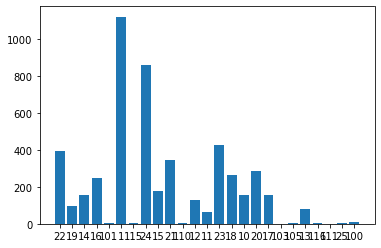

Max value: 25


In [12]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 14


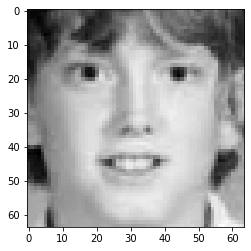

In [13]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

## Feature extraction and Normalization

- Sure! This code extracts Histogram of Oriented Gradients (HOG) features from a list of preprocessed images, normalizes the features to have zero mean and unit variance, and stores them in a NumPy array called hog_features_norm

In [14]:
# Extract HOG features from the images
hog_features = []
for img in images:
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

C:\Users\afbso\AppData\Local\Temp\ipykernel_26748\1933635154.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),


- For each preprocessed image in images, extract the HOG features using the hog() function from scikit-image. The orientations, pixels_per_cell, and cells_per_block parameters control the number of orientations, the size of the cells, and the number of cells per block used in the feature extraction process. The transform_sqrt parameter applies power law compression to normalize the local contrast of the image. The feature_vector parameter flattens the HOG descriptor into a 1D array. The multichannel and channel_axis parameters are used to indicate that the input image has three channels. The resulting HOG feature is then appended to the hog_features list.

## SVM

In [15]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

Samples in Training: 4000
Samples in Testing: 1000


In [16]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.728
